# **Global Sentiment**

En este cuaderno mostraremos la forma de extraer el *Sentimiento Global*, métrica que hemos desarrollado para este proyecto.

## ¿Que es el Sentimiento Global?

Normalmente, cuando miramos el "sentimiento" de un Tweet, lo hacemos fijandonos en la polaridad del mismo. Una vez se consiguen todas las polaridades, la mayoria de herramientas que hemos visto, usan la media del "sentimiento" como medida de Sentimiento Global en Twitter.

Nosotros rechazamos esta idea. 

Para encontrar una métrica más efectiva, planteamos la siguiente fórmula:

$$S(P) = \sum_{m \in P} m_s * (1 + \log_2(1 + m_l))$$

donde $S(P)$ es un mapeo de una lista de mensajes a un número real, $P$ es una lista de mensajes de un periodo conexo de tiempo, $m_s$ es la polaridad de un mensaje y $m_l$ es el *impacto* de un tweet, en este caso, los likes.

Se pueden considerar diferentes formas de impacto haciendo uso del número de contestaciones, retweets, likes, likes a las contestaciones, etc, pero en este estudio vamos a mantener la simplicidad.


## Imports y Parametros

In [1]:
import datetime
from datetime import timedelta

import os
import re

import snscrape.modules.twitter as snstwitter

import pandas as pd
import seaborn as sns
import numpy as np

import matplotlib.pyplot as plt

Podemos escoger las fechas que queremos analizar. Para poder analizarlas, debemos tener los archivos de las fechas correspondientes descargados, sino no podremos ejecutar el analisis.

In [2]:
date_init = "2017-01-02"
date_limit = "2021-06-14"

## **Read Databases**

Definimos la carpeta donde se encuentran los datos así como los nombres de los archivos.

In [3]:
t_path = "JABA/data/tweets"
t_file = "tweet_list.csv"
s_file = "tweet_sentiment_nltk.csv"

La base de datos esta formada por millones de filas y no usaremos todas las columnas, por lo que, para acelerar el proceso, eliminaremos las columnas no usadas.

In [4]:
unused_columns = ['Text', 'Tweet Id', 'NumReplies', 'NumRetweets', 'IDOriginalRetweeted', 'isVerified'  ]

def drop_unused_columns(dataframe):
    return dataframe.drop(unused_columns,  axis=1)

Para preparar los datos haremos un conjunto de transformaciones que tienen los siguientes objetivos:

* Preparar la fila de Sentimiento Global
* Agrupar los datos por cada media hora
* Preparar la fila de Sentimiento Global V2

In [5]:
def prepare_data(dataframe):
    dataframe["Datetime"] = pd.to_datetime(dataframe["Datetime"])
    dataframe['sentiment_v'] = ( 1 + np.log2(1 + dataframe['NumLikes']) ) * dataframe['sentiment'] 
    dataframe["round_datetime"] = dataframe["Datetime"].dt.floor("30T")
    
    dataframe["date"] = dataframe["Datetime"].dt.date
    dataframe = dataframe.set_index('date')
    
    dataframe = dataframe.groupby(['round_datetime', 'Username']).agg({'sentiment_v' : 'sum' , 'Datetime':'count'})
    dataframe['sentiment_v2'] = np.log2(1+dataframe['Datetime']) / dataframe['Datetime'] * dataframe['sentiment_v']
    return dataframe.groupby('round_datetime').sum()

Definimos una función que recoja los archivos de las fechas correspondientes, los limpie y los una.

In [6]:
def get_data():
    frames = []
    date_from = datetime.datetime.strptime(date_init, '%Y-%m-%d').date()
    date_until = datetime.datetime.strptime(date_limit, '%Y-%m-%d').date()
    
    if date_from >= date_until:
        return pd.DataFrame()
    
    while date_from < date_until:
        
        folder = os.path.join(t_path, str(date_from))
        # TODO Check if file exists
        if date_from.day == 1 and date_from.month == 1:
            print(f"Current Date {str(date_from)}")

        tweet_file = os.path.join(folder, t_file)
        sentiment_file = os.path.join(folder, s_file)

        tweet_df = pd.read_csv(tweet_file, sep=";")
        tweet_df = drop_unused_columns(tweet_df)

        sent_df = pd.read_csv(sentiment_file, sep=";")

        tweet_df = prepare_data(tweet_df.join(sent_df))
        
        frames += [tweet_df]
        
        date_from = date_from + timedelta(days=1)
    
    return pd.concat(frames, ignore_index=False)

In [7]:
df = get_data()
print("Extraction Completed!")

Step 365 : JABA/data/tweets\2018-01-01
Step 730 : JABA/data/tweets\2019-01-01
Step 1095 : JABA/data/tweets\2020-01-01
Step 1460 : JABA/data/tweets\2020-12-31


## **Get Bitcoin Data**

In [13]:
b_path = "JABA/data/bitcoin"
b_file = "bitcoin.csv"

b_limit = date_limit

In [15]:
btc_df = pd.DataFrame()

frames = []
date_from = datetime.datetime.strptime(date_init, '%Y-%m-%d').date()
date_until = datetime.datetime.strptime(date_limit, '%Y-%m-%d').date()

while date_from < date_until:

    folder = os.path.join(b_path, str(date_from))
    btc_file = os.path.join(folder, b_file)
    # TODO Check if file exists
    if date_from.day == 1 and date_from.month == 1:
        print(f"Current Date {str(date_from)}")

    b_df = pd.read_csv(btc_file, sep=";")
    frames += [b_df]

    date_from = date_from + timedelta(days=1)

btc_df = pd.concat(frames, ignore_index=False)
print("Extraction Completed!")

Current Date 2018-01-01
Current Date 2019-01-01
Current Date 2020-01-01
Current Date 2021-01-01
Extraction Completed


In [16]:
# Pasar los formatos a los tipos correspondientes
btc_df['round_datetime'] = pd.to_datetime(btc_df['round_datetime'])
btc_df['timestamp'] = pd.to_datetime(btc_df['timestamp'])

# Pasar las fechas a index para filtrar datos entre fechas indicadas
btc_df = btc_df.set_index('round_datetime')

# Filtrar entre fechas
btc_df = btc_df[date_init:date_limit]

# Aproximar a periodos de 30 minutos
btc_df['timestamp_round'] = btc_df['timestamp'].dt.floor('30T')

# Sustituir los 0's por el último valos no-zero
btc_df['Close'] = btc_df['Close'].replace(to_replace=0, method='ffill')

# Agrupar y hacer la media
btc_df = btc_df.groupby("timestamp_round").mean()

## **Juntar Datos**

In [17]:
btc_df.index = btc_df.index.tz_localize(None)
df.index = df.index.tz_localize(None)

In [18]:
merge = pd.merge(df,btc_df, how='inner', left_index=True, right_index=True)
#merge = pd.merge(merge,df_gb_c, how='inner', left_index=True, right_index=True)

In [19]:
del df, btc_df

## **Mostrar resultados**

In [29]:
merge['Close_z'] = merge['Close']
merge['sentiment_vz'] = merge['sentiment_v'] * 52
merge['sentiment_v2z'] = merge['sentiment_v2'] * 52

Text(0, 0.5, 'Price (USD)')

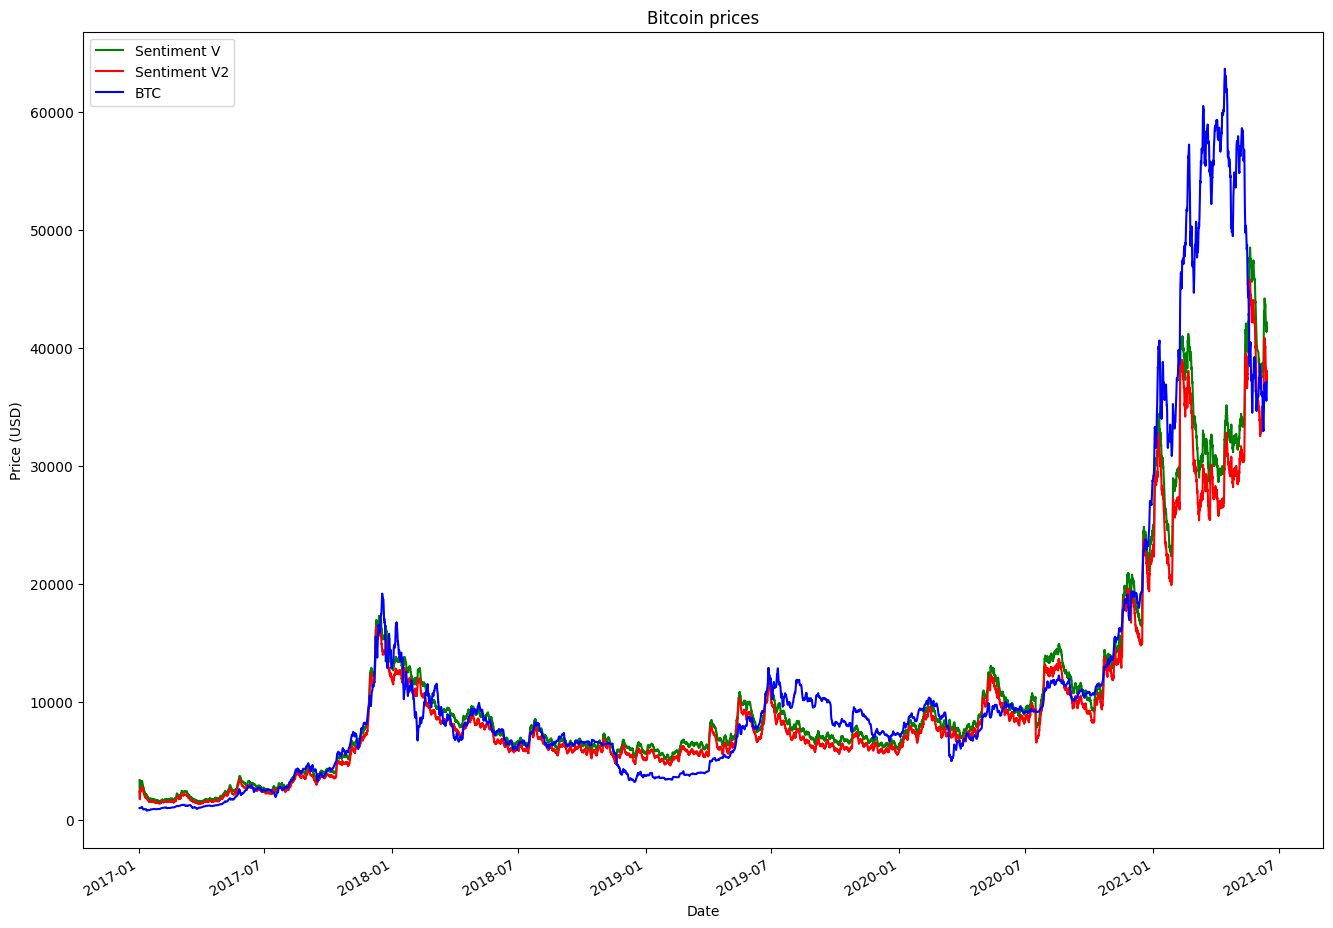

In [30]:
plt.rcParams['figure.figsize'] = [16, 12]
plt.rcParams['figure.dpi'] = 100

merge['sentiment_vz'].ewm(span = 600).mean().plot(style = 'g', label = 'Sentiment V')
merge['sentiment_v2z'].ewm(span = 500).mean().plot(style = 'r', label = 'Sentiment V2')
merge['Close_z'].ewm(span = 40).mean().plot(style = 'b', label = 'BTC')


plt.legend()
plt.title("Bitcoin prices")
plt.xlabel('Date')
plt.ylabel('Price (USD)')

--------------------------------------------------
Index of the max corr 12
Max corr 0.8645152152736361
--------------------------------------------------


<AxesSubplot:>

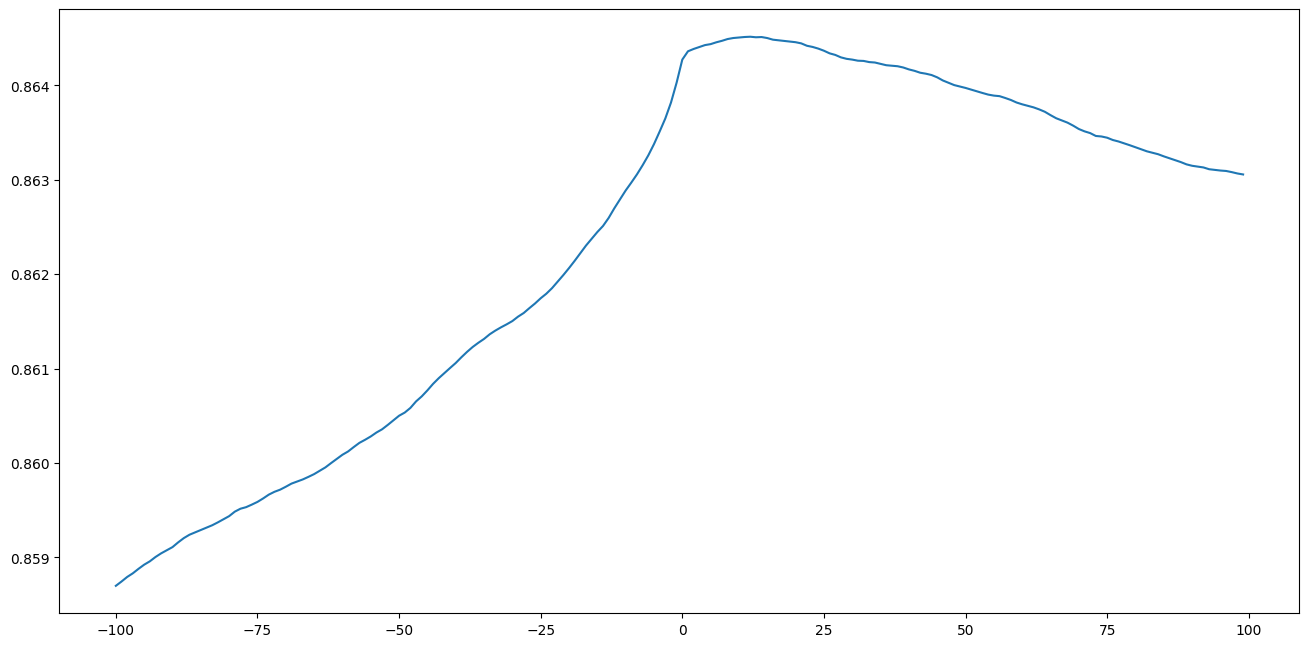

In [26]:
plt.rcParams['figure.figsize'] = [16, 8]
plt.rcParams['figure.dpi'] = 100

coor_data = []

corr_index_range = 100

for i in range(-corr_index_range,corr_index_range):
    merge2 = merge.shift(periods=i)
    #print(f"Con shift %i el corr es %.4f " % (i, merge2['sentiment_zz'].corr(merge['Close'])))
    coor_data += [merge2['sentiment_v2z'].corr(merge['Close_z'])]

print("-"*50)
print(f"Index of the max corr {-corr_index_range+coor_data.index(max(coor_data))}")
print(f"Max corr {max(coor_data)}")
print("-"*50)

sns.lineplot(x = range(-100,100), y=coor_data)